In [1]:
import numpy as np
# библиотека для вывода на консоль массивов
import matplotlib.pyplot
# убедитесь, что участки находятся внутри этой записной книжки, а не внешнего окна
%matplotlib inline
#plt.show() # Вместо %matplotlib inline в других средах, не notebook
from time import time, sleep #Для замера времени выполнения функций
from tqdm import tqdm #Для вывода прогресса вычисления функций
# glob помогает выбрать несколько файлов, используя шаблоны
import glob
# помощник для загрузки данных из файлов изображений PNG
import scipy.misc

In [2]:
# Загрузить mnist тренировочные данные в формате CSV 
training_data_file = open("MNIST_dataset/mnist_train.csv", 'r') # 'r' - открываем файл для чтения
training_data_list = training_data_file.readlines() # readlines() - читает все строки в файле в переменную training_data_list
training_data_file.close() # закрываем фаел csv

In [3]:
# Определение класса нейронной сети
class neuron_Net:
    
    # инициализация нейронной сети
    def __init__(self, input_num, hidden_num, output_num, learningrate): #констр.(входной слой, скрытый слой, выходной слой)
                                            # ВХОДНЫЕ ДАННЫЕ
        self.m = 28 #Размер входного массива(ДхШ)
        self.k = 5 #Размер ядер (ДхШ)        
        self.m_k_1 = (self.m-self.k)+1 #Размер карты свойств скрытого слоя1 (ДхШ)
        self.m_k = self.m-self.k
        self.stob_w = self.k*self.k #Количество элементов 1го ядра свертки
        self.m_k1_1 = (self.m_k_1 - self.k)+1 #Размер  карты свойств скрытого слоя2(ДхШ)
        self.stok_w1 = 9 #Число ядер свертки1
        
        self.x1 = np.zeros((self.m_k_1, self.m_k_1)) #Скрытый слой1
        self.x2 = np.zeros((self.stok_w1, self.m_k1_1, self.m_k1_1)) #Скрытый слой2
                        
        #Для вывода карт свойст скрытого слоя (для их визуального просмотра)  
        self.hidden_outputs_image = np.zeros((self.m_k_1, self.m_k_1))
        self.hidden_outputs_image1 = np.zeros((self.stok_w1, self.m_k1_1, self.m_k1_1))
        
                                            # МАТРИЦЫ ВЕСОВ
        # Значения в ядре1
        self.weights = np.random.normal(0.0, pow(self.stob_w, -0.5), (self.k, self.k))
        # Значения в ядрах2
        self.weights2 = np.random.normal(0.0, pow(self.stob_w, -0.5), (self.stok_w1, self.k, self.k))
        self.weights2_rot_180 = self.weights2 # Шаблон для перевернутой матрицы ядер весов2
        # Значения в весов выходного слоя
        self.weights_out = np.random.normal(0.0, pow(hidden_num, -0.5), (output_num, hidden_num)) #20*20*9
        
        # Создадим матрицу размера ошибки1 - как показано на слайде
        # Нулевая матрица размера (для помещения значений ошибок в ее центр)
        self.hidden_errors0_temp = np.zeros((self.stok_w1, self.m_k_1+self.k-1, self.m_k_1+self.k-1))
        self.hidden_errors0 = np.zeros((self.stok_w1, self.m_k_1, self.m_k_1))

        # скорость обучения
        self.lr = learningrate
        
        # функция активации-функция сигмоида
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass

    
    # обучение нейронной сети
    def train(self, inputs_list, targets_list): # принемает входной список данных,targets ответы
        # Преобразовать список входов в 2D массив
        inputs_x = np.array(inputs_list.reshape(self.m , self.m)) # матрица числа
        # Преобразовать список ответов в вертикальный массив. .T - транспонирование
        targets_Y = np.array(targets_list, ndmin=2).T # матрица ответов какое это число
                
                                        # ВЫЧИСЛЕНИЕ СИГНАЛОВ ПО СЛОЯМ
        # вычислить сигналы в скрытом слое1 (карты сигналов скрытого слоя1). СВЁРТКА!
        for h in range(self.m_k_1):
            for w in range(self.m_k_1):
                self.x1[h,w] = np.sum(inputs_x[h:h+self.k, w:w+self.k] * self.weights)
        
        # вычислить сигналы, возникающие из скрытого слоя0. сигмоида(сигнал скр.слоя)
        y1 = self.activation_function(self.x1)
        
        # вычислить сигналы в скрытом слое2 (карты сигналов скрытого слоя2). СВЁРТКА!            
        for s in range(self.stok_w1):
            for h in range(self.m_k1_1):
                for w in range(self.m_k1_1):
                    self.x2[s,h,w] = np.sum(y1[h:h+self.k, w:w+self.k] * self.weights2[s])
        
        # вычислить сигналы, возникающие из скрытого слоя. сигмоида(сигнал скр.слоя)
        y2 = self.activation_function(self.x2)
        
        # вычислить сигналы в окончательный выходной слой (матрица сигналов выходного слоя)
        x3 = np.dot(self.weights_out, np.array(y2.flatten(), ndmin=2).T) # сигнал вых.слоя = вес скр. слоя * значение сигнала скр.слоя
        # вычислить сигналы, исходящие из конечного выходного слоя. сигмоида(сигнал вых.слоя)
        y3 = self.activation_function(x3)
        
                                            # ВЫЧИСЛЕНИЕ ОШИБКИ ПО СЛОЯМ
        #  ошибка выходного слоя является (цель - фактическое) 
        E = -(targets_Y - y3)
        # Ошибка скрытого слоя2
        E_hidden = np.dot(self.weights_out.T, E)
        E_hidden = E_hidden.reshape(self.stok_w1, self.m_k1_1, self.m_k1_1) # преобразование ошибки скрытого слоя2 в 3D
        
        # Запоминаем значения перевернутых ядер весов2
        for s in range(self.stok_w1):
            self.weights2_rot_180[s] = np.fliplr(self.weights2[s])
            self.weights2_rot_180[s] = np.flipud(self.weights2_rot_180[s])
        
        # Поместим в центр нулевой матрицы большего размера, ошибку на предыдущем слое
        for s in range(self.stok_w1):
            self.hidden_errors0_temp[s, self.k-1:self.m_k1_1+self.k-1, self.k-1:self.m_k1_1+self.k-1] = E_hidden[s]
            
        # Проходим по этой матрице перевернутыми весами
        for s in range(self.stok_w1):
            for h in range(self.m_k_1):
                for w in range(self.m_k_1):
                    self.hidden_errors0[s,h,w] = np.sum(self.hidden_errors0_temp[s, h:h+self.k, w:w+self.k] * self.weights2_rot_180[s] 
                                                        * (1 - y1[h, w]) * (y1[h, w]))
                                                
        # Cумма ошибки (значения храним в 1м массиве)
        for s in range(self.stok_w1-1):
            self.hidden_errors0[0] = self.hidden_errors0[s] + self.hidden_errors0[s+1]
        # Запоминаем в отдельную переменную сумму ошибок
        hidden_errors0 = self.hidden_errors0[0]
                
                                            # ОБНОВЛЕНИЕ ВЕСОВ ПО СЛОЯМ
        # Обновления весов ядер связей между скрытым и выходным слоями(скрытый слой2)
        self.weights_out -= self.lr * np.dot((E * y3 * (1.0 - y3)), np.transpose(np.array(y2.flatten(), ndmin=2).T))
        # обновления весов связей между скрытыми слоями             
        for s in range(self.stok_w1):
            for h in range(self.m_k_1-(self.m_k1_1)+1):
                for w in range(self.m_k_1-(self.m_k1_1)+1):
                    #Запоминаем локальную область скрытого слоя1
                    inputs_t = y1[h:h+self.m_k1_1, w:w+self.m_k1_1]
                    #Переворачиваем на 180 локальную область скрытого слоя1
                    inputs_t = np.fliplr(inputs_t)
                    inputs_t = np.flipud(inputs_t)
                    #Обновляем веса скрытого слоя1
                    self.weights2[s, h, w] -= np.sum(E_hidden[s] * inputs_t * self.lr)
                    
        # Обновления весов ядра связи между скрытым и входным слоем
        for h in range(self.m-(self.m_k_1)+1):
            for w in range(self.m-(self.m_k_1)+1):
                #Запоминаем локальную область входных данных
                inputs_t = inputs_x[h:h+self.m_k_1, w:w+self.m_k_1]
                #Переворачиваем на 180 локальную область входных данных
                inputs_t = np.fliplr(inputs_t)
                inputs_t = np.flipud(inputs_t)
                #Обновляем веса входных данных
                self.weights[h, w] -=  np.sum(hidden_errors0 * inputs_t * self.lr)
                    
                    
        #Запоминаем карту свойст скрытого слоя для их визуального просмотра            
        self.hidden_outputs_image = y1
        self.hidden_outputs_image1 = y2
        pass

                                        # МЕТОД ПРОГОНА СВОИХ ЗНАЧЕНИЙ ПО СЕТИ
    # запросить нейронную сеть
    def query(self, inputs_list): # Функция прогонки по слоям своих данных. Принемает свой набор тестовых данных
        # Преобразовать список входов в 2D массив
        inputs_x = np.array(inputs_list.reshape(self.m , self.m)) # матрица числа
        
        # вычислить сигналы в скрытом слое1 (карты сигналов скрытого слоя1). СВЁРТКА!
        for h in range(self.m_k_1):
            for w in range(self.m_k_1):
                self.x1[h,w] = np.sum(inputs_x[h:h+self.k, w:w+self.k] * self.weights)
        
        # вычислить сигналы, возникающие из скрытого слоя0. сигмоида(сигнал скр.слоя)
        y1 = self.activation_function(self.x1)
        
        # вычислить сигналы в скрытом слое2 (карты сигналов скрытого слоя2). СВЁРТКА!            
        for s in range(self.stok_w1):
            for h in range(self.m_k1_1):
                for w in range(self.m_k1_1):
                    self.x2[s,h,w] = np.sum(y1[h:h+self.k, w:w+self.k] * self.weights2[s])
        
        # вычислить сигналы, возникающие из скрытого слоя. сигмоида(Xhidden - сигнал скр.слоя)
        y2 = self.activation_function(self.x2)
        
        # вычислить сигналы в окончательный выходной слой (матрица сигналов выходного слоя)
        x3 = np.dot(self.weights_out, np.array(y2.flatten(), ndmin=2).T) # сигнал вых.слоя = вес скр. слоя * значение сигнала скр.слоя
        # вычислить сигналы, исходящие из конечного выходного слоя. сигмоида(сигнал вых.слоя)
        y3 = self.activation_function(x3)
        
        return y3      

In [4]:
# количество входных, скрытых и выходных узлов
data_input = 784
data_hidden = 3600 #20x20x9
data_output = 10

# скорость обучения
learningrate = 0.05

# Создать экземпляр нейронной сети
n = neuron_Net(data_input, data_hidden, data_output, learningrate)

In [5]:
                                                      # ОБУЧЕНИЕ
# Зададим количество эпох
epochs = 1

start = time()
# Прогон по обучающей выборке
for e in range(epochs):
    # Пройдите все записи в наборе тренировочных данных    
    #for record in training_data_list:
    for i in tqdm(training_data_list, desc = str(e+1)): # tqdm - используем интерактив состояния прогресса вычисления
        # Получить входные данные числа
        all_values = i.split(',') # split(',') - раздел строку на символы где запятая "," символ разделения
        # Массив данных входа с масштабированием от 0,01 до 0,99
        inputs_x = (np.asfarray(all_values[1:])/ 255.0 * 0.99) + 0.01 # Игнорируем нулевой индекс, где целевое значение
        
        # Получить целевое значение Y, (ответ - какое это число)
        targets_Y = int(all_values[0])  # перевод символов в int, 0 элемент - целевое значение
        
        # создать целевые выходные значения (все 0.01, кроме нужной метки, которая равна 0.99)
        targets_Y = np.zeros(data_output) + 0.01
        
        # Получить целевое значение Y, (ответ - какое это число). all_values[0] - целевая метка для этой записи
        targets_Y[int(all_values[0])] = 0.99
            
        n.train(inputs_x, targets_Y) # наш метод train - обучение нейронной сети
        
        pass
    pass

time_out = time() - start
print("Время выполнения: ", time_out, " сек" )

1: 100%|███████████████████████████████████████████████████████████████████████| 60000/60000 [1:05:32<00:00, 15.26it/s]


Время выполнения:  3932.404888153076  сек


In [6]:
# Загрузить CSV-файл данных теста mnist в список
test_data_file = open("mnist_dataset/mnist_test.csv", 'r') # 'r' - файл для чтения, а не для записи.
test_data_list = test_data_file.readlines()  # readlines() - читает все строки в файле в переменную test_data_list
test_data_file.close() # закрываем фаел csv

In [7]:
# ПРОВЕРКА ЭФФЕКТИВНОСТИ НЕЙРОННОЙ СЕТИ
# Массив показателей эффективности сети, изначально пустой
efficiency = []

# Прогон по всем записям в наборе тестовых данных
#for i in test_data_list:
for i in tqdm(test_data_list):
    # Получить входные данные числа 
    all_values = i.split(',') # split(',') - раздел строку на символы где запятая "," символ разделения
    # Правильный ответ, хранимый в нулевом индексе
    targets_Y = int(all_values[0])
    # Массив данных входа с масштабированием от 0,01 до 0,99
    inputs_x = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01 # Игнорируем нулевой индекс, где целевое значение

    # Запросить ответ у сети
    outputs_y = n.query(inputs_x) # Прогон по сети тестового значения из нашего файла
    # Индекс самого высокого значения на матрице выхода, соответствует метке числа
    label_y = np.argmax(outputs_y) # argmax возвращает индекс максимального элемента в выходном массиве
    
    # Добавить правильный или неправильный список
    if (label_y == targets_Y): # Если индекс макс. знач. на выходе = целевому значению (0 индекс массива данных)
        # Если ответ сети соответствует целевому значению, добавляем 1 в конец массива показателей эффективности
        efficiency.append(1)
    else:
        # Если ответ сети не соответствует целевому значению, добавляем 0 в конец массива показателей эффективности
        efficiency.append(0)
        
        pass
    
    pass

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:32<00:00, 47.11it/s]


In [8]:
# Вычислить оценку производительности. Доля правильных ответов
efficiency_map = np.asarray(efficiency) # asarray - преобразование списка в массив 

print ('Производительность = ', (efficiency_map.sum() / efficiency_map.size)*100, '%') # Среднее арифметическое

Производительность =  70.76 %


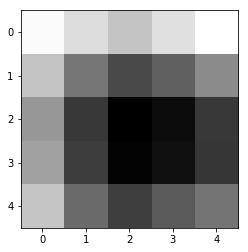

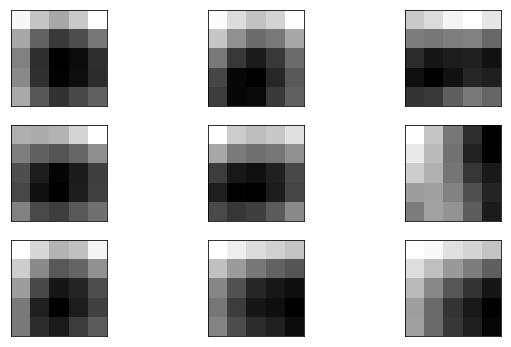

In [9]:
# Данные изображения в ядрах свертки скрытого слоя2
# получить данные изображения с индексом "0". Для крупного масштаба.
image_y1 = n.weights2[0]
# вывод данных изображения участка с индексом "0".
matplotlib.pyplot.imshow(image_y1, cmap='Greys', interpolation='None')

fig = matplotlib.pyplot.figure(figsize=(10,6))
for j in range(9):
    ax = fig.add_subplot(3, 3, j+1)
    ax.imshow(n.weights2[j], 
              cmap=matplotlib.cm.binary, interpolation='none')
    matplotlib.pyplot.xticks(np.array([]))
    matplotlib.pyplot.yticks(np.array([]))
matplotlib.pyplot.show()

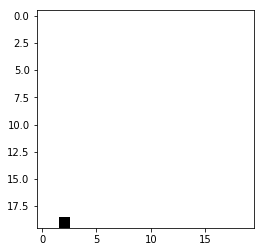

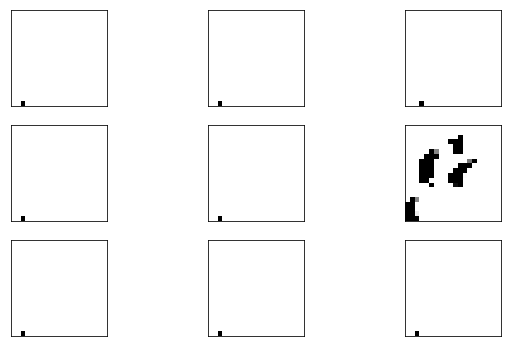

In [10]:
# Данные изображения в признаках скрытого слоя2
# получить данные изображения признака скрытого слоя2
image_o2 = n.hidden_outputs_image1[0]
# данные изображения участка
matplotlib.pyplot.imshow(image_o2, cmap='Greys', interpolation='None')

# получить данные изображения признака скрытого слоя1
fig = matplotlib.pyplot.figure(figsize=(10,6))
for j in range(9):
    ax = fig.add_subplot(3, 3, j+1)
    ax.imshow(n.hidden_outputs_image1[j], 
              cmap=matplotlib.cm.binary, interpolation='none')
    matplotlib.pyplot.xticks(np.array([]))
    matplotlib.pyplot.yticks(np.array([]))
matplotlib.pyplot.show()

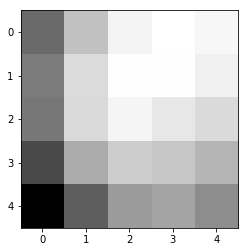

In [11]:
# Данные изображения в ядрах свертки скрытого слоя1
# получить данные изображения с индексом "0". Для крупного масштаба.
image_y1 = n.weights
# вывод данных изображения 
matplotlib.pyplot.imshow(image_y1, cmap='Greys', interpolation='None')

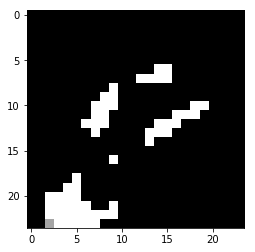

In [12]:
# Данные изображения в признаках скрытого слоя1
# получить данные изображения признака скрытого слоя1
image_o2 = n.hidden_outputs_image
# данные изображения участка
matplotlib.pyplot.imshow(image_o2, cmap='Greys', interpolation='None')